In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import inspect
engine = create_engine('sqlite:///mito_macs.db')

In [ ]:
# Load to RAM
data_1 = pd.read_csv('/Users/ginomontero/Documents/mito-macro-project/data/raw/doi_10_5061_dryad_ksn02v7fn__v20250930/Results_gc_length_corrected_WT_LPS_1h__VS__5019_LPS_1h.csv')
data_1.head()
# Write to SQL
data_1.to_sql('rnaseq_de', engine, index=False, if_exists='replace')
# Confrim success
print("✅ Data loaded! Rows:", len(data_1))

✅ Data loaded! Rows: 9392


In [ ]:
# Get database inspector
inspector = inspect(engine)
# Verify rnaseq_de exists
print('Tables:', list(inspector.get_table_names()))
# Preview data
pd.read_sql("SELECT * FROM rnaseq_de LIMIT 5;", engine)

Tables; ['rnaseq_de']


,GeneID,GeneName,logFC,logCPM,LR,PValue,FDR,5019C_LPS_1h,5019B_LPS_1h,5019A_LPS_1h,WT1_LPS_1h,WT2_LPS_1h,WT3_LPS_1h
0,ENSMUSG00000039109,F13a1,3.302428,5.394185,203.362031,3.856481e-46,3.622007e-42,6.557690,6.041807,5.819894,3.245697,3.166062,3.144942
1,ENSMUSG00000048806,Ifnb1,2.585461,5.413712,110.268004,8.559917e-26,4.019737e-22,5.806795,5.660881,6.710503,2.878252,3.388903,3.469628
2,ENSMUSG00000035105,Egln3,2.555116,3.427532,98.808072,2.781982e-23,8.709458e-20,4.427768,4.071693,3.786016,1.936227,1.497667,1.906343
3,ENSMUSG00000017737,Mmp9,2.713670,3.061242,94.606417,2.322641e-22,5.453562e-19,4.029180,3.662910,3.624412,1.030333,1.269196,1.313177
4,ENSMUSG00000028527,Ak4,1.674123,3.824246,53.574950,2.489131e-13,4.675584e-10,4.562845,4.319910,4.080629,3.069907,3.071635,2.559947


In [ ]:
inspector.get_columns('rnaseq_de')

[{'name': 'GeneID',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'GeneName',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'logFC',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'logCPM',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'LR',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'PValue',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'FDR',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': '5019C_LPS_1h',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': '5019B_LPS_1h',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': '5019A_LPS_1h',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},


In [ ]:
pd.read_sql("""
SELECT
    COUNT(*) AS total_genes,
    SUM(CASE WHEN PVALUE < 0.05 THEN 1 ELSE 0 END) AS significant_genes
FROM rnaseq_de
""", engine)

,total_genes,significant_genes
0,9392,689


In [ ]:
pd.read_sql("""
SELECT GeneName, logFC, PVALUE
FROM rnaseq_de
WHERE PVALUE < 0.05 AND logFC > 1
ORDER BY logFC DESC
LIMIT 20
""", engine)

,GeneName,logFC,PValue
0,F13a1,3.302428,3.856481e-46
1,Mmp9,2.713670,2.322641e-22
2,Ifnb1,2.585461,8.559917e-26
3,Egln3,2.555116,2.781982e-23
4,Ak4,1.674123,2.489131e-13
5,Mgl2,1.668817,8.716991e-06
6,Mmp8,1.551921,3.471883e-06
7,Acta2,1.545999,1.159020e-04
8,Prelid2,1.503988,4.256420e-04
9,Acod1,1.479389,8.118539e-09


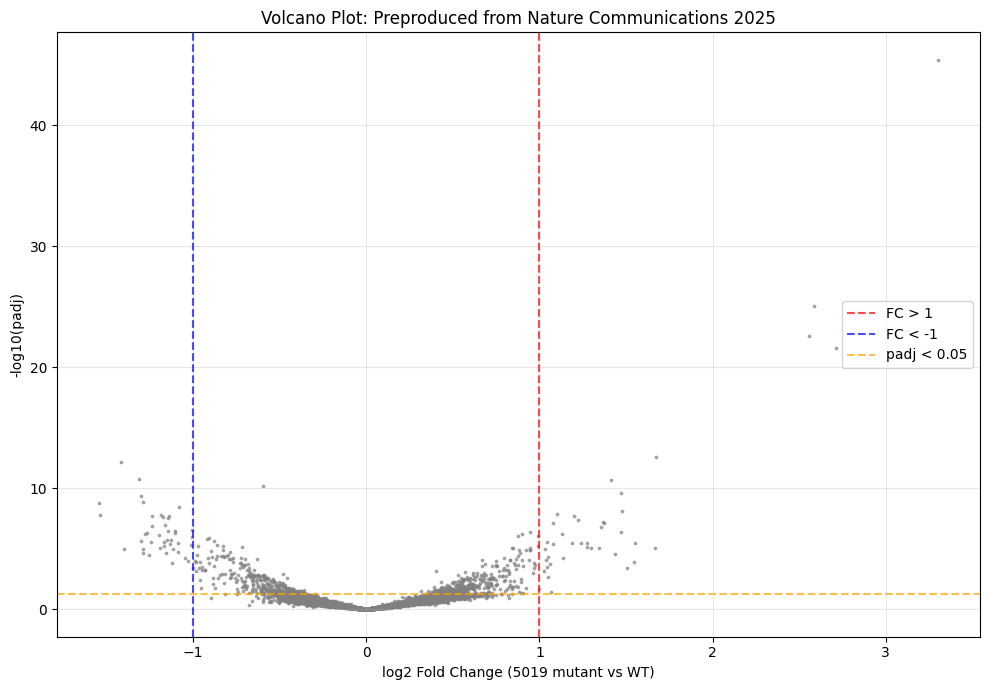

In [ ]:
volcano = pd.read_sql("SELECT logFC, PValue FROM rnaseq_de WHERE PValue > 0", engine)
volcano['neg_log10_padj'] = -np.log10(volcano['PValue'].clip(lower=1e-300))

plt.figure(figsize=(10, 7))
plt.scatter(volcano['logFC'], volcano['neg_log10_padj'], s=3, alpha=0.6, c='gray')
plt.axvline(1, color='red', ls='--', alpha=0.7, label='FC > 1')
plt.axvline(-1, color='blue', ls='--', alpha=0.7, label='FC < -1')
plt.axhline(-np.log10(0.05), color='orange', ls='--', alpha=0.7, label='padj < 0.05')
plt.xlabel('log2 Fold Change (5019 mutant vs WT)')
plt.ylabel('-log10(padj)')
plt.title('Volcano Plot: Preproduced from Nature Communications 2025')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()